# Setup

In [1]:
!pip install -q tf-models-official==2.3.0
!pip install transformers

In [2]:
import os
import json, pickle

import pandas as pd
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import transformers
from transformers import BertTokenizer, TFBertModel
transformers.logging.set_verbosity_error() # suppress tokenizer sentences' length warnings
tf.get_logger().setLevel('ERROR')

import keras
from keras import Model
from keras.utils import plot_model
from keras.layers import Input, Dense, Flatten, Dropout, Activation
from datetime import datetime

from google.colab import drive, files

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Settings


In [4]:
### PARAMETERS ###
RANDOM_STATE = 42

# Dataset creation
SEQUENCE_LIMIT = 512
STRIDE = 256

SHUFFLE = True

TRAIN_LIMIT = None  # set None for the full size
VAL_LIMIT = None    # set None for the full size

# Model Training
EPOCHS = 3
BATCH_SIZE = 8

# dataset drive settings
SAVE_DATASET = False
LOAD_DATASET = True

# model weights drive settings
SAVE_WEIGHTS = False
LOAD_WEIGHTS = True
LOAD_LOSS = True
LOADING_EPOCH = 2   # epoch from which weights and losses are resumed

# training settings
TRAIN = True

# Dataset

In [5]:
try:
  with open('training_set.json') as f:
    json_data = json.load(f)
except:
  with open('/content/drive/My Drive/SQUAD/training_set.json') as f:
    json_data = json.load(f)

In [6]:
# Creates DataFrames with useful columns by unpacking 'paragraphs' column
def unpack_df(df):
  temp = []
  title_dict = {}
  contexts = []

  for i, row in df.iterrows():
    for context in row['paragraphs']:
      contexts.append(context['context'])
      for qa in context['qas']:
        question_id = qa['id']
        question = qa['question']
        for answer in qa['answers']:
          answer_text = answer['text']
          answer_start = answer['answer_start']
          answer_end = answer_start+len(answer_text)
          temp.append([question_id, question, answer_text, answer_start, answer_end, i, len(contexts)-1])

  context_dict = dict(enumerate(contexts))
  df = pd.DataFrame(temp, columns=['question_id', 'question_text', 'answer_text', 'answer_start', 'answer_end', 'title_id', 'context_id'])
  
  return df, context_dict

# Read data from json
data = pd.json_normalize(json_data['data'])

# Split train and test
train, val = train_test_split(data, test_size=0.10, random_state=RANDOM_STATE)

# Create DataFrames with useful columns
train_df, train_context_dict = unpack_df(train)
val_df, val_context_dict = unpack_df(val)

# Shuffle DataFrame
if SHUFFLE:
  train_df = train_df.sample(frac = 1, random_state=RANDOM_STATE)
  val_df = val_df.sample(frac = 1, random_state=RANDOM_STATE)

train_df

,question_id,question_text,answer_text,answer_start,answer_end,title_id,context_id
74875,57265dc9dd62a815002e82d2,Is there a pplace where lovers of the chicken ...,"In many countries, national and regional poult...",0,101,191,16131
40064,57269a03708984140094cb57,What was Nathan Hale famous for?,Revolutionary War soldier,4,29,234,8561
957,5730a771069b53140083220d,How many cultures may have fused together in E...,three,320,325,411,220
43425,5709bb3ded30961900e8445a,Who is in favor of a zero inflation policy?,some economists,287,302,129,9236
66501,56bfb502a10cfb140055125e,How much did she earn in 2014?,115 million,1660,1671,1,14328
...,...,...,...,...,...,...,...
6265,5725e72a271a42140099d2f6,Judea was ruled by whom during the Hellenistic...,High Priest of Israel,301,322,185,1346
54886,5726bff8708984140094d06b,At what age did Avicenna turn to away from phi...,16,25,27,254,11785
76820,572f880804bcaa1900d76a55,Name two major events of the Seven Years' War ...,"the expulsion of the Acadians, the siege of Qu...",67,117,359,16550
860,57303f17b2c2fd1400568ae3,What type of assembly could specific groupings...,concilia,714,722,395,199


In [7]:
# Inspect data samples
def print_squad_sample(train_data, context_dict, line_length=120, separator_length=150):

  sample = train_data.sample(frac=1).head(1)
  context = context_dict[sample['context_id'].item()]

  print('='*separator_length, '\nCONTEXT:\n', '='*separator_length)

  lines = [''.join(context[idx:idx+line_length]) for idx in range(0, len(context), line_length)]
  for l in lines:
      print(l)

  print('='*separator_length, '\nQUESTION:', ' '*(3*separator_length//4), 'ANSWER:')

  questions = train_data[train_data['context_id'] == sample['context_id'].item()]

  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), answer)

print_squad_sample(train_df, train_context_dict)

CONTEXT:
A format called quiet storm is often included in urban adult contemporary, and is often played during the evening, blend
ing the urban AC and soft AC styles of music. The music that is played is strictly ballads and slow jams, mostly but not
 limited to Black and Latino artists. Popular artists in the quiet storm format are Teena Marie, Freddie Jackson, Johnny
 Gill, Lalah Hathaway, Vanessa L. Williams, Toni Braxton, and En Vogue among others.
QUESTION:                                                                                                                  ANSWER:
Along with Freddie Jackson, Johnny Gill, Teena Marie, Lalah Hathaway, Toni Braxton, and En Vogue, what artist is popular on quiet storm stations?  Vanessa L. Williams
What is the typical ethnicity of artists played on quiet storm stations?                                                   Black and Latino
What is the name of the radio format that is a mixture of urban and soft adult contemporary?             

## Tokenizer

In [8]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

print('[[CLS], [SEP]] = {}'.format(tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])))

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(train_df['question_text'][0])

# Print out the tokens.
print('\nTokenized sentence:')
print(tokenized_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indices.
print('\n{:<12} {:>6}\n'.format('TOKENS', 'INDICES'))
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6}'.format(tup[0], tup[1]))

[[CLS], [SEP]] = [101, 102]

Tokenized sentence:
['what', 'language', 'is', 'the', 'word', 'dialect', '##us', 'from', '?']

TOKENS       INDICES

what           2054
language       2653
is             2003
the            1996
word           2773
dialect        9329
##us           2271
from           2013
?              1029


## Prepare data for model

In [9]:
# Prints COOL progress bar (No, seriously, it's really cool!)
# REALLY DUDE, THIS STUFF IS GOLD
def print_progress(value, total, bar_width=100):
  perc = int(value/total*bar_width)
  rest = bar_width - perc
  print("\r{:>3} % [ {}{} ]".format(perc, perc*'■', rest*'─'), end="")

# ensure to preserve all sub-sequences of length limi-stride. 
def split_long_sequence(my_sequence, limit, stride):

  if len(my_sequence) <= limit: 
    return [my_sequence]
  
  rest = my_sequence
  split = []
  while len(rest) > limit:
    left_hand = rest[:limit]
    rest = rest[stride:]
    split.append(left_hand)
    
  split.append(rest)
  return split

# Returns start and end indices of sublist in list
def find_sublist(a, b):
  if len(a) == 0 or len(b) == 0:
    raise Exception("Lists with length 0")
    
  for i in range(len(a) - len(b) +1):
    if np.array_equal(a[i:i+len(b)], b):
      return i, i+len(b)-1
  return -1, -1

In [10]:
def from_df_to_model_dict(df, context_dict, verbose=False):

  # initialize structures
  question_id = []
  question_text = []
  context_id = []
  answer_text = []
  input_ids = []
  input_mask = []
  input_type_ids = []
  start_indexes = []
  end_indexes = []

  cut_counter = 0
  max_iter = len(df)
  new_entries = 0
  for i, (_, row) in enumerate(df.iterrows()):

    # print progress
    if (i+1) % (max_iter // 100) == 0 or i == 0:
      print_progress(i+1, max_iter)

    # encode question and context
    if verbose: print("\tTokenizing question and context...", end="")
    encoded_question = tokenizer.encode(row['question_text'])
    encoded_context = tokenizer.encode(context_dict[row['context_id']])[1:]

    # concatenate input data 
    if verbose: print("\tChecking sequence length...")
    if len(encoded_question + encoded_context) > SEQUENCE_LIMIT:
      # if the sequence is too long, split it in n subsequences of length <= SEQUENCE_LIMIT
      encoded_contexts = split_long_sequence(encoded_context,
                                             limit=SEQUENCE_LIMIT-len(encoded_question), 
                                             stride=STRIDE)
      cut_counter += 1
    else:
      encoded_contexts = [encoded_context]
    
    new_entries += len(encoded_contexts)-1
    # for each too long sequence, the context has been split in n parts. We need to process them separately, creating new entries for the input
    for context_piece in encoded_contexts:
      
      encoded_input = encoded_question + context_piece

      # create mask of ones
      ones_mask = tf.ones_like(encoded_input)

      # add padding and convert to tensor
      if verbose: print("\tPadding...", end="")
      encoded_input = tf.keras.preprocessing.sequence.pad_sequences([encoded_input], maxlen=512, padding='pre')
      encoded_input = tf.squeeze(tf.convert_to_tensor(encoded_input))

      # processing answer indices
      if verbose: print("\tProcessing answer...", end="")
      tokenized_answer = tokenizer.encode(row['answer_text'])[1: -1]
      start_idx, end_idx = find_sublist(encoded_input, tokenized_answer)

      start_indexes.append(start_idx)
      end_indexes.append(end_idx)


      # create input_type_ids
      if verbose: print("\tInput types creation...", end="")
      type_ids = tf.concat([tf.zeros_like(encoded_question, dtype=tf.int32), 
                            tf.ones_like(context_piece, dtype=tf.int32)], 
                          axis=-1)
      
      type_ids = tf.keras.preprocessing.sequence.pad_sequences([type_ids], maxlen=512, padding='pre')
      type_ids = tf.squeeze(tf.convert_to_tensor(type_ids))


      # create mask of zeros
      if verbose: print("\tMask creation...", end="")
      zeros_mask = tf.zeros(SEQUENCE_LIMIT - len(ones_mask), dtype=tf.int32)
      mask = tf.concat([zeros_mask, ones_mask], axis=-1)

      # append elements to lists
      if verbose: print("\tAppending inputs...", end="")
      question_id.append(row['question_id'])
      question_text.append(row['question_text'])
      context_id.append(row['context_id'])
      answer_text.append(row['answer_text'])
      input_ids.append(encoded_input)
      input_mask.append(mask)
      input_type_ids.append(type_ids)

  # save input data as dictionary
  data = {
    'question_id': question_id,
    'question_text': question_text,
    'answer_text': answer_text,
    'context_id': context_id,
    'input_ids': tf.convert_to_tensor(input_ids),
    'attention_mask': tf.convert_to_tensor(input_mask),
    'token_type_ids': tf.convert_to_tensor(input_type_ids),
    'start_idx': start_indexes,
    'end_idx': end_indexes,
    }

  assert len(input_ids) == len(df) + new_entries, f"ATTENTION:\nci sono {len(input_ids)} input_ids, MA {len(df)} righe nel df e {new_entries} nuove entries"
  return data

# Building Dataset

In [11]:
if not LOAD_DATASET:
  print("Building training set...")
  train = from_df_to_model_dict(train_df[:TRAIN_LIMIT], train_context_dict)

  print("\n\nBuilding validation set...")
  val = from_df_to_model_dict(val_df[:VAL_LIMIT], val_context_dict)

# Index to categorical


In [12]:
if not LOAD_DATASET: 
  # Replace -1 (answer not found) with 0
  train['start_idx'] = [val if val != -1 else 0 for val in train['start_idx']]
  train['end_idx'] = [val if val != -1 else 0 for val in train['end_idx']]

  val['start_idx'] = [val if val != -1 else 0 for val in val['start_idx']]
  val['end_idx'] = [val if val != -1 else 0 for val in val['end_idx']]

  # from ints to categorical
  train['start_cat'] = tf.keras.utils.to_categorical(train['start_idx'], num_classes=SEQUENCE_LIMIT)
  train['end_cat'] = tf.keras.utils.to_categorical(train['end_idx'], num_classes=SEQUENCE_LIMIT)

  val['start_cat'] = tf.keras.utils.to_categorical(val['start_idx'], num_classes=SEQUENCE_LIMIT)
  val['end_cat'] = tf.keras.utils.to_categorical(val['end_idx'], num_classes=SEQUENCE_LIMIT)

  # Inspect data
  assert len(train['start_idx']) == len(train['end_idx']) == len(train['input_ids']) == len(train['attention_mask']) == len(train['token_type_ids'])
  assert len(val['start_idx']) == len(val['end_idx']) == len(val['input_ids']) == len(val['attention_mask']) == len(val['token_type_ids'])

  print("Shapes")
  print("\nTrain starts:\t", train['start_cat'].shape)
  print("Train ends:\t", train['end_cat'].shape)
  print("\nVal starts:\t", val['start_cat'].shape)
  print("Val ends:\t", val['end_cat'].shape)

# Save data to Drive

In [13]:
if SAVE_DATASET:

  # TRAIN
  with open("/content/drive/MyDrive/SQUAD/train.p", "wb") as f:
    pickle.dump(train, f)
  with open("/content/drive/MyDrive/SQUAD/train_context_dict.p", "wb") as f:
    pickle.dump(train_context_dict, f)

  # VALIDATION
  with open("/content/drive/MyDrive/SQUAD/val.p", "wb") as f:
    pickle.dump(val, f)
  with open("/content/drive/MyDrive/SQUAD/val_context_dict.p", "wb") as f:
    pickle.dump(val_context_dict, f)

# Load data from Drive

In [14]:
if LOAD_DATASET:

  # TRAIN
  with open("/content/drive/MyDrive/SQUAD/train.p", "rb") as f:
    train = pickle.load(f)
  with open("/content/drive/MyDrive/SQUAD/train_context_dict.p", "rb") as f:
    train_context_dict = pickle.load(f)

  # VALIDATION
  with open("/content/drive/MyDrive/SQUAD/val.p", "rb") as f:
    val = pickle.load(f)
  with open("/content/drive/MyDrive/SQUAD/val_context_dict.p", "rb") as f:
    val_context_dict = pickle.load(f)

In [15]:
print("Shapes")
print("\nTrain starts:\t", train['start_cat'].shape)
print("Train ends:\t", train['end_cat'].shape)
print("\nVal starts:\t", val['start_cat'].shape)
print("Val ends:\t", val['end_cat'].shape)

assert train['start_cat'].shape == train['end_cat'].shape
assert val['start_cat'].shape == val['end_cat'].shape

Shapes

Train starts:	 (80200, 512)
Train ends:	 (80200, 512)

Val starts:	 (7524, 512)
Val ends:	 (7524, 512)


# Build model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                

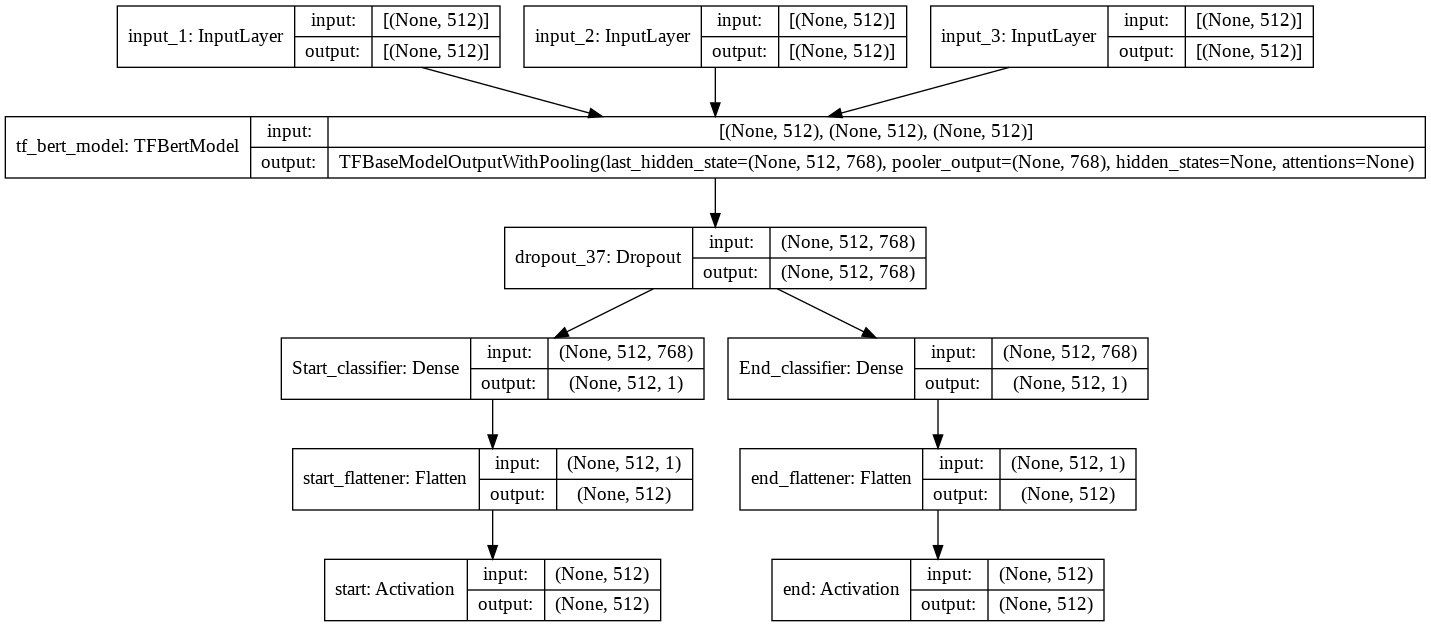

In [16]:
def build_model():

  # Define Input layers
  input_ids_layer = Input(shape = (512,), dtype='int64')
  attention_mask_layer = Input(shape = (512,), dtype='int64')
  token_ids_layer = Input(shape = (512,), dtype='int64')

  # Load Bert model
  bert_model = TFBertModel.from_pretrained('bert-base-uncased')
  
  bert_model.trainable = True
  
  # Initialize bert model
  bert = bert_model([input_ids_layer,
                    attention_mask_layer,
                    token_ids_layer],
                    return_dict = False,
                    output_attentions = False,
                    output_hidden_states = False
                    ).last_hidden_state
  
  # Dropout
  dropout = Dropout(0.2)(bert)

  # Classifiers
  start_classifier = Dense(units=1, name="Start_classifier")(dropout)
  end_classifier = Dense(units=1, name="End_classifier")(dropout)

  # Flatteners
  start_flat = Flatten(name="start_flattener")(start_classifier)
  end_flat = Flatten(name="end_flattener")(end_classifier)

  # Activations
  start_softmax = Activation(tf.keras.activations.softmax, name="start")(start_flat)
  end_softmax = Activation(tf.keras.activations.softmax, name="end")(end_flat)

  # Build model
  model = Model(inputs=[input_ids_layer, attention_mask_layer, token_ids_layer], 
                outputs=[start_softmax, end_softmax])
  
  model.summary()
  return model

model = build_model()
plot_model(model, show_shapes=True)

In [17]:
# Define model parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08
                                     #, clipnorm=1.0
                                     )
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train

In [18]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [ ]:
if TRAIN:

  for i in range(EPOCHS):

    history = LossHistory()
    
    # Fit model with train set
    model_fit = model.fit(x = [train['input_ids'][:TRAIN_LIMIT],
                              train['attention_mask'][:TRAIN_LIMIT],
                              train['token_type_ids'][:TRAIN_LIMIT]],
                          y = (np.array(train['start_idx'][:TRAIN_LIMIT], dtype=np.float32),
                              np.array(train['end_idx'][:TRAIN_LIMIT], dtype=np.float32)),
                              
                              batch_size = BATCH_SIZE,
                              epochs = 1, 
                              callbacks = [history],
                              
                              validation_data=([val['input_ids'][:VAL_LIMIT],
                                                val['attention_mask'][:VAL_LIMIT],
                                                val['token_type_ids'][:VAL_LIMIT]],
                                                (np.array(val['start_idx'][:VAL_LIMIT], dtype=np.float32),
                                                np.array(val['end_idx'][:VAL_LIMIT], dtype=np.float32))
                                              )
                              )
      
    if SAVE_WEIGHTS:
      model.save_weights(f'/content/drive/MyDrive/SQUAD/weights_epoch_{i+1}.h5')
      
    with open(f"/content/drive/MyDrive/SQUAD/Losses/losses_epoch_{i+1}.p", "wb") as f:
      pickle.dump(history.losses, f)
    with open(f"/content/drive/MyDrive/SQUAD/Losses/val_loss_epoch_{i+1}.p", "wb") as f:
      pickle.dump(model_fit.history['val_loss'][0], f)
    with open(f"/content/drive/MyDrive/SQUAD/Losses/val_acc_epoch_{i+1}.p", "wb") as f:
      pickle.dump((model_fit.history['val_start_accuracy'][0] + model_fit.history['val_end_accuracy'][0])/2, f)

  294/10025 [..............................] - ETA: 2:38:58 - loss: 7.4086 - start_loss: 3.8004 - end_loss: 3.6082 - start_accuracy: 0.1689 - end_accuracy: 0.1856

## Loss plotting

In [ ]:
if LOAD_WEIGHTS:
    model.load_weights(f'/content/drive/MyDrive/SQUAD/weights_epoch_{LOADING_EPOCH}.h5')

if LOAD_LOSS:
  losses = []
  
  for i in range(EPOCHS):
    with open(f"/content/drive/MyDrive/SQUAD/Losses/val_loss_epoch_{i+1}.p", "rb") as f:
      val_losses = pickle.load(f)
  
    with open(f"/content/drive/MyDrive/SQUAD/Losses/val_acc_epoch_{i+1}.p", "rb") as f:
      val_accuracies = pickle.load(f)
  
    with open(f"/content/drive/MyDrive/SQUAD/Losses/losses_epoch_{i+1}.p", "rb") as f:
      losses.append(pickle.load(f))
    
    print("Epoch {} - validation loss: {:.2f} - validation accuracy: {:.2f}".format((i+1), val_losses, val_accuracies))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

plt.title("Training losses")
plt.xlabel("Batch")
plt.ylabel("Loss")

plt.plot(losses[0], label='Epoch 1')
plt.plot(losses[1], label='Epoch 2')
plt.plot(losses[2], label='Epoch 3')
plt.legend()

plt.show()

# Test

## Compute predictions

In [ ]:
# Predict test set
pred = model.predict([val["input_ids"][:VAL_LIMIT], 
                      val["attention_mask"][:VAL_LIMIT], 
                      val["token_type_ids"][:VAL_LIMIT]],
                      verbose = 1)

pred_start_ids = np.argmax(pred[0], axis=-1)
pred_end_ids = np.argmax(pred[1], axis=-1)

## Compute scores

In [ ]:
start_acc  = accuracy_score(val['start_idx'][:VAL_LIMIT], pred_start_ids)
end_acc    = accuracy_score(val['end_idx'][:VAL_LIMIT], pred_end_ids)
start_f1   = f1_score(val['start_idx'][:VAL_LIMIT], pred_start_ids, average="macro")
end_f1     = f1_score(val['end_idx'][:VAL_LIMIT], pred_end_ids, average="macro")

In [ ]:
def most_similar_answer(context, answer):

  original_answer = answer
  
  answer = answer.replace(" %", "%")
  answer = answer.replace(" . ", " ")
  answer = answer.replace(" '", "")
  answer = answer.replace(' "', '')
  answer = answer.replace(" “", "")
  answer = answer.replace(" ”", "")
  answer = answer.replace(" , ", " ")
  answer = answer.replace(" ;", "")
  answer = answer.replace(" - ", "-")
  answer = answer.replace(" – ", "–")
  answer = answer.replace(" (", " ")
  answer = answer.replace(" )", " ")
  
  context = context.replace(".", "")
  context = context.replace(", ", " ")
  context = context.replace(";", "")
  context = context.replace('"', '')
  context = context.replace("“", "")
  context = context.replace("”", "")
  context = context.replace("'", " ")
  context = context.replace("\"", "")
  context = context.replace("(", "")
  context = context.replace(")", "")

  answer_list = answer.split(" ")
  context_list = context.split(" ")

  for i, element in enumerate(context_list):
    lowered = []
    for token in context_list[i:i+len(answer_list)]:
      lowered.append(token.lower())
    
    if lowered == answer_list:
      return True, ' '.join(context_list[i:i+len(answer_list)])
  
  return False, original_answer

In [ ]:
def get_text_from_token_ids(context, start_id, end_id):
  return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(context[start_id:end_id+1]))

# Initialize variables
outputs_dict = {}       # output dictionary in requested format ('question_id': 'answer_text')
exact_match = 0         # exact match counter
exact_match_strings = 0 # exact match between the two strings counter
start_greater_end = 0   # start greater than end counter

for i, input_ids in enumerate(val['input_ids'][:VAL_LIMIT]):

  # Extract variables
  question_id = val['question_id'][i]
  question_text = val["question_text"][i]
  context = val_context_dict[val["context_id"][i]]
  true_start = val['start_idx'][i]
  true_end = val['end_idx'][i]
  pred_start = pred_start_ids[i]
  pred_end = pred_end_ids[i]

  # Extract answers
  true_answer = val['answer_text'][i]
  predicted_answer = get_text_from_token_ids(input_ids, pred_start, pred_end)

  # Convert answer (if possible)
  convert_flag, converted_answer = most_similar_answer(context, predicted_answer)

  # Count exact matches
  if pred_start == true_start and pred_end == true_end:
    exact_match += 1
  
  # Count start greaters than ends
  if pred_start > pred_end:
    start_greater_end += 1

  # If answer not found
  if pred_start == 0 and pred_end == 0:
    converted_answer = ""

  # Count exaact matches between strings
  if true_answer == converted_answer:
    exact_match_strings += 1

  # Write answer dictionary
  outputs_dict[question_id] = converted_answer

  # Print some examples
  if i % 1000 == 0:
    print("\n\nQuestion: \n", question_text)
    print("Context: \n", context)

    print(f"True answer: \n\tids {(true_start, true_end)}\t\ttext: {true_answer}")
    print(f"Our answer: \n\tids {(pred_start, pred_end)}\t\ttext: {converted_answer}")
    
    if convert_flag:
      print("(was converted)")

    print("\n", "-"*50)

In [ ]:
print("Test starts greater than ends: {}/{} ({:.2f}%)".format(start_greater_end, len(val['input_ids'][:VAL_LIMIT]), start_greater_end/len(val['input_ids'][:VAL_LIMIT])*100))

In [ ]:
print("Test exact matches between strings: {}/{} ({:.2f}%)".format(exact_match_strings, exact_match, exact_match_strings/exact_match*100))

## Save results to Drive

In [ ]:
time = datetime.now().strftime("%d-%m-%Y_%H:%M")

with open(f"/content/drive/MyDrive/SQUAD/Results/results_{time}.txt", "w") as f:

  f.write(f"TEST start accuracy: {start_acc}")
  f.write(f"\nTEST start f1-score: {start_f1}")

  f.write(f"\n\nTEST end accuracy: {end_acc}")
  f.write(f"\nTEST end f1-score: {end_f1}")

  f.write("\n\nTest exact matches: {}/{} ({:.2f}%)".format(exact_match,
                                                           len(val['input_ids'][:VAL_LIMIT]),
                                                           exact_match/len(val['input_ids'][:VAL_LIMIT])*100))

with open(f"/content/drive/MyDrive/SQUAD/Outputs/outputs_{time}.json", 'w') as fp:
    json.dump(outputs_dict, fp)

## Load results from Drive

In [ ]:
with open(f"/content/drive/MyDrive/SQUAD/Results/results_{time}.txt", "r") as f:
  for line in f.readlines():
    print(line, end="")

with open(f"/content/drive/MyDrive/SQUAD/Outputs/outputs_{time}.json", "r") as f:
  outputs_dict = json.load(f)